In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: Tesla T4


dataset loading

In [4]:
# 1. Install Kaggle library
!pip install -q kaggle

# 2. Upload your kaggle.json file
from google.colab import files
print("Upload your kaggle.json file:")
files.upload()

# 3. Setup Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# 5. Unzip the data
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.75GB/s]


dataset analysis

Classes: ['REAL', 'FAKE']


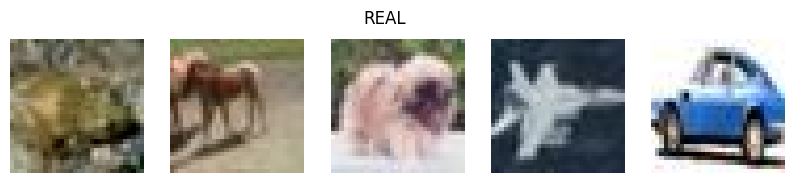

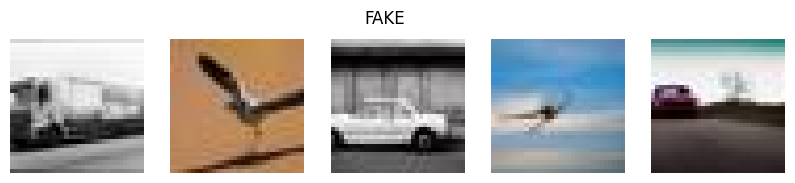

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = "train"

classes = os.listdir(dataset_path)
print("Classes:", classes)

# Show random images from each class
def show_samples(class_name, n=5):
    class_path = os.path.join(dataset_path, class_name)
    images = random.sample(os.listdir(class_path), n)

    plt.figure(figsize=(10,2))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(class_path, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(class_name)
    plt.show()

for c in classes:
    show_samples(c)

data set normalisation

In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder("train", transform=transform)
test_dataset = ImageFolder("test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'FAKE': 0, 'REAL': 1}


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda")

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 46.8MB/s]


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

def train_model(model, loader, epochs=5):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}, Accuracy {100*correct/total:.2f}%")

train_model(model, train_loader, epochs=15)

100%|██████████| 782/782 [05:20<00:00,  2.44it/s]


Epoch 1: Loss 0.4687, Accuracy 79.09%


100%|██████████| 782/782 [05:08<00:00,  2.53it/s]


Epoch 2: Loss 0.3530, Accuracy 85.47%


100%|██████████| 782/782 [05:07<00:00,  2.54it/s]


Epoch 3: Loss 0.3274, Accuracy 86.34%


100%|██████████| 782/782 [04:56<00:00,  2.63it/s]


Epoch 4: Loss 0.3150, Accuracy 86.81%


100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Epoch 5: Loss 0.3087, Accuracy 87.10%


100%|██████████| 782/782 [05:09<00:00,  2.53it/s]


Epoch 6: Loss 0.3040, Accuracy 87.21%


100%|██████████| 782/782 [05:05<00:00,  2.56it/s]


Epoch 7: Loss 0.3003, Accuracy 87.33%


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


Epoch 8: Loss 0.2968, Accuracy 87.58%


 12%|█▏        | 94/782 [00:35<04:13,  2.71it/s]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.show()

evaluate(model, test_loader)

In [1]:
!pip freeze > requirements.txt